In [1]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=4e1576e9cdb0be54224859bfc6e3fc64733de1e5e54c38c2287df556ccd1ea9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-memx4un9/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [1]:
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import en_core_web_lg

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
#Importing packages for later
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib.font_manager import FontProperties
import re

In [4]:
#Read in the scrape results
rgame = pd.read_csv('rgaming_comments.csv')#,sep = '\t')
#Read in the ps5 xbox csv file. 
model_brand = pd.read_csv('ps5_xbox.csv', header = None, sep=',')
model_brand.columns = ['brand','model']
#names = ['brand','model'], sep=',')
rgame[:5]

,submission,author,body,score,created,url_of_post
0,hdtabn,TheTinyPlunger,I actually thought you had the real thing for ...,3416,1.592838e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...
1,hdtabn,Eaglezzz,**PLEASE DRINK VERIFICATION CAN TO CONTINUE**,946,1.592842e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...
2,hdtabn,Damascusmascus,They got really intimidated by the [KFConsole]...,232,1.592839e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...
3,hdtabn,SevenHarmlessSins,What kind of criminal keeps a banana in a fridge?,137,1.592846e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...
4,hdtabn,Thebaldymaster,Did you make that all you're self???,140,1.592837e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...


In [5]:
model_brand

,brand,model
0,xbox,xbox series one x
1,xbox,xbox series one
2,xbox,xbox one
3,xbox,xbox series one s
4,xbox,xbox series 1x
5,xbox,xbox series 1s
6,xbox,xbox series x
7,xbox,xbox series s
8,xbox,xbox 1
9,xbox,xbox 1x


In [6]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from nltk import pos_tag, word_tokenize
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
## Create dictionary for model to brand mapping
model_brand = model_brand.set_index('model')
model_brand_dict = model_brand["brand"].to_dict()

In [8]:
stop = stopwords.words('english')

rgame["body"] = rgame["body"].astype(str)
rgame["comments_tokens"] = rgame["body"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
rgame["comments_tokens"] = rgame["comments_tokens"].apply(lambda list_of_words: [x if x not in model_brand_dict else model_brand_dict[x] for x in list_of_words])
rgame["comments_tokens"] = rgame["comments_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])


In [9]:
## Get all the unique tokens in each comments
rgame["comments_unique"] = rgame["comments_tokens"].apply(lambda x: sorted(set(x)))
rgame

,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique
0,hdtabn,TheTinyPlunger,I actually thought you had the real thing for ...,3416,1.592838e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[actually, thought, real, thing, second, great...","[3d, actually, great, real, second, thing, tho..."
1,hdtabn,Eaglezzz,**PLEASE DRINK VERIFICATION CAN TO CONTINUE**,946,1.592842e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[please, drink, verification, continue]","[continue, drink, please, verification]"
2,hdtabn,Damascusmascus,They got really intimidated by the [KFConsole]...,232,1.592839e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[got, really, intimidated, kfconsole, https, y...","[et6uiw7uzw4, got, https, intimidated, kfconso..."
3,hdtabn,SevenHarmlessSins,What kind of criminal keeps a banana in a fridge?,137,1.592846e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[kind, criminal, keeps, banana, fridge]","[banana, criminal, fridge, keeps, kind]"
4,hdtabn,Thebaldymaster,Did you make that all you're self???,140,1.592837e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[make, self]","[make, self]"
...,...,...,...,...,...,...,...,...
1556,gj2fd2,parkwayy,Before whoever whines about how games won't lo...,80,1.589401e+09,/r/gaming/comments/gj2fd2/a_tech_demo_running_...,"[whoever, whines, games, look, good, beastly, ...","[beastly, better, com, crap, demo, eh, games, ..."
1557,gj2fd2,intLeon,This but with hoverboard : one of the opening ...,75,1.589389e+09,/r/gaming/comments/gj2fd2/a_tech_demo_running_...,"[hoverboard, one, opening, scenes, treasure, p...","[1ainh4, edit, euwu, g6h3vs_qb6s, got, hoverbo..."
1558,gj2fd2,davejugs01,That is fucking incredible,51,1.589388e+09,/r/gaming/comments/gj2fd2/a_tech_demo_running_...,"[fucking, incredible]","[fucking, incredible]"
1559,gj2fd2,Sovereign42,"Looks neat, now as long as this is footage of ...",110,1.589389e+09,/r/gaming/comments/gj2fd2/a_tech_demo_running_...,"[looks, neat, long, footage, rendered, real, t...","[actually, footage, hardware, impressed, junk,..."


##Lift analysis of brands

In [10]:
## Get frequency of all words
all_words = rgame['comments_unique'].sum()
freq_dist = nltk.FreqDist(all_words)

In [11]:
## Get the frequency counts of all brands
all_brands_dict = {your_key: freq_dist[your_key] for your_key in freq_dist.keys() if your_key in model_brand_dict.values()}
all_brands = pd.DataFrame.from_dict(all_brands_dict, orient='index').reset_index()
all_brands.columns = ["brand","word_frequency"]
all_brands.sort_values("word_frequency", ascending= False, inplace=True)

###ranking

In [12]:
## Display the brands ranking by frequency count
top_brands = all_brands.head(3)
top10 = all_brands.head(3)
top_brands

,brand,word_frequency
1,xbox,109
2,ps5,89
0,pc,44


###Lift function

In [13]:
def calculate_lift(a, b, tokenized_posts):
    num_a = 0
    num_b = 0
    num_a_b = 0
    n = len(tokenized_posts)
    if a==b:
        return 1
    for i in tokenized_posts:
        if a in i:
            num_a += 1
        if b in i:
            num_b += 1
        if a in i and b in i:
            num_a_b += 1
    if num_a == 0:
        return (float(n)*num_a_b)/(num_b)
    elif num_b == 0:
        return (float(n)*num_a_b)/(num_a)
    else:
        return (float(n)*num_a_b)/(num_a*num_b)

In [14]:
## Get the lift scores for the top-10 brands
num_brands = 3

## print(top_brands)
top_brands = top_brands.head(num_brands)
lift_brands = []
for index, brand_a in top_brands.iterrows():
    for index, brand_b in top_brands.iterrows():
        lift_brands.append(calculate_lift(brand_a.brand, brand_b.brand, rgame.comments_unique))

In [15]:
lift_brands_df = np.reshape(lift_brands,(num_brands,num_brands))

### console to console Lift Matrix

In [16]:
lift_brands = pd.DataFrame(data= lift_brands_df)

for i in range(3):
    lift_brands = lift_brands.rename(columns = {i: top_brands.iloc[i, 0]})
    lift_brands = lift_brands.rename(index = {i: top_brands.iloc[i, 0]})
lift_brands

,xbox,ps5,pc
xbox,1.000000,1.930935,2.603837
ps5,1.930935,1.000000,2.391726
pc,2.603837,2.391726,1.000000


In [ ]:
###MDS plot

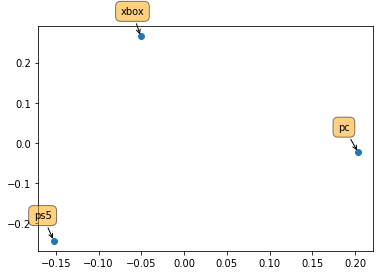

In [17]:
## Calculating the dissimilarity matrix which is the input for plotting MDS plot
dissimilarity_matrix = 1/lift_brands
np.fill_diagonal(dissimilarity_matrix.values, 0)

## Plotting MDS plot
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(lift_brands, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points',ha = 'left', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

##Attribute Analysis using lift

In [18]:
attribute_list = ['performance','graphics','affordable','favorite','buy','speed',
                 'price','security','fps','games','multiplayer','online','subscription',
                  'quality']
attr_df = pd.DataFrame(index = attribute_list)
attr_df['synonym'] = attribute_list
attr_df[:5]

,synonym
performance,performance
graphics,graphics
affordable,affordable
favorite,favorite
buy,buy


In [19]:
attr_dict = attr_df["synonym"].to_dict()
rgame["attr_tokens"] = rgame["comments_unique"].apply(lambda list_of_words: [attr_dict[x] for x in list_of_words if x in attr_dict  ])

In [20]:
# Define consoles by frequency obtained previously
import numpy as np
top_brands=['xbox','ps5','pc']

# Get unique list of grouped attribute names
uniq_attr=np.unique(attr_df['synonym'])
uniq_attr

array(['affordable', 'buy', 'favorite', 'fps', 'games', 'graphics',
       'multiplayer', 'online', 'performance', 'price', 'quality',
       'security', 'speed', 'subscription'], dtype=object)

In [21]:
# Find top 5 attributes:

def calc_freq(tokenized_posts,find_list):
    freq_a=0
    for i in tokenized_posts:
        if find_list in i:
            freq_a += 1
    return freq_a
  
# Calculate freq for attr
df_top_attr=pd.DataFrame(columns=['attribute','freq'])
for i,attr in enumerate(uniq_attr):
        temp_freq=calc_freq( rgame.comments_unique,str(attr))
        df_top_attr.loc[i]=[str(attr),temp_freq]

In [22]:
top_attr=df_top_attr.sort_values(by='freq',ascending=False).head(5)
top_attr['attribute']

4       games
1         buy
7      online
5    graphics
9       price
Name: attribute, dtype: object

In [23]:
# Grouped Brands and attribute lifts 
df_lift_brand_attr=pd.DataFrame(columns=['brand','attribute','lift'])
i=0
for  brand_a in top_brands:
    for attr in top_attr['attribute']:
        temp_lift=calculate_lift(str(brand_a), str(attr), rgame.comments_unique)
        df_lift_brand_attr.loc[i]=[ str(brand_a),str(attr),temp_lift]
        i=i+1

In [24]:
df1 = df_lift_brand_attr.sort_values('lift',ascending = False).groupby('brand').head(10)
print(df1.sort_values(['brand','lift'],ascending=[True,False]))

   brand attribute      lift
10    pc     games  5.543324
13    pc  graphics  3.547727
14    pc     price  3.547727
11    pc       buy  3.130348
12    pc    online  1.970960
8    ps5  graphics  1.753933
9    ps5     price  1.753933
6    ps5       buy  1.031725
5    ps5     games  0.548104
7    ps5    online  0.000000
4   xbox     price  2.864220
0   xbox     games  2.237672
1   xbox       buy  0.842418
2   xbox    online  0.795617
3   xbox  graphics  0.000000


In [25]:
lift_matrix = df1.pivot(index='brand', columns='attribute')
lift_matrix

lift                                        
attribute       buy     games  graphics    online     price
brand                                                      
pc         3.130348  5.543324  3.547727  1.970960  3.547727
ps5        1.031725  0.548104  1.753933  0.000000  1.753933
xbox       0.842418  2.237672  0.000000  0.795617  2.864220

##Aspiration Analysis

In [26]:
aspiration_list = ['wish to', 'hope to', 'want to', 'really want', 'prefer', 'dream graphics', 'dream of', 'aspire', 'looking for', 'looking to', 'would like', 'can afford', 'looking at', 'pre order','pre_order', 'cop']

In [27]:
aspiration = pd.DataFrame(aspiration_list)
aspiration.columns=['word']
aspiration

,word
0,wish to
1,hope to
2,want to
3,really want
4,prefer
5,dream graphics
6,dream of
7,aspire
8,looking for
9,looking to


In [28]:
## Function to replace the aspirational phrases with the word - "aspiration"
def asp_word_replace(comment):
    for i in aspiration['word'].index.values:
        comment = comment.lower().replace(aspiration['word'][i],'aspiration')
    return comment

In [29]:
rgame["comments_replace"] = rgame["body"].apply(asp_word_replace)

In [30]:
## Tokenize the comments and remove stop words after replacing the phrases by aspiration
rgame["comments_replace_tokens"] = rgame["comments_replace"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
rgame["comments_replace_tokens"] = rgame["comments_replace_tokens"].apply(lambda list_of_words: [x if x not in model_brand_dict else model_brand_dict[x] for x in list_of_words])
rgame["comments_replace_tokens"] = rgame["comments_replace_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])
rgame["comments_replace_tokens"] = rgame["comments_replace_tokens"].apply(lambda x: sorted(set(x)))

In [31]:
## Get the lift score for all brands and aspirational words
lift_asp_brands = pd.DataFrame(columns=['Brand','Lift'])
for index, brand_a in all_brands.iterrows():
        lift_asp_brands = lift_asp_brands.append({'Brand': brand_a.brand, "Lift":calculate_lift(brand_a.brand, 'aspiration', rgame.comments_replace_tokens)},
                                        ignore_index=True)

In [32]:
lift_asp_brands.sort_values(by='Lift',ascending=False).head(5)

,Brand,Lift
2,pc,3.835381
0,xbox,2.322341
1,ps5,1.422108


Casual gamers would prefer to buy a PC. comparing just PS5 and XBOX, xbox wins

#Sentiment Analysis


###Word frequency analysis using POS

In [33]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer # to remove punctuations
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
#clean_comment accepts a string. It then cleans the comment by removing punctuation and stopwords.
#It returns a list of words in that string.
def clean_comment(comment):
    #For cleaning up the test comment. Remove punctuation and make everything lower case.
    comment = re.sub(r'[^\w\s]','',comment.lower())
    
    #Syntax translation:
    #word can be anything. I choose word since it's what we're essentially doing
    #comment.split() converts the comment into a list. 
    #Then see if the word in that list is in the drop_stop or not. 
    #Drops any word that is in the stopwords list.
    stopwords_list = stopwords.words('english')
    #Store this list and return it.
    cleaned = [word for word in comment.split() if word not in stopwords_list]
    return cleaned

In [35]:
#Use function to create a new cleaned body column.
rgame['cleaned body'] = rgame['body'].astype(str).apply(clean_comment)

In [36]:
# Obtain POS for the tokens
nltk.download('averaged_perceptron_tagger')

rgame['pos']=rgame['cleaned body'].apply(nltk.tag.pos_tag)
rgame[:5]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos
0,hdtabn,TheTinyPlunger,I actually thought you had the real thing for ...,3416,1.592838e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[actually, thought, real, thing, second, great...","[3d, actually, great, real, second, thing, tho...",[],i actually thought you had the real thing for ...,"[3d, actually, great, real, second, thing, tho...","[actually, thought, real, thing, second, great...","[(actually, RB), (thought, VBN), (real, JJ), (..."
1,hdtabn,Eaglezzz,**PLEASE DRINK VERIFICATION CAN TO CONTINUE**,946,1.592842e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[please, drink, verification, continue]","[continue, drink, please, verification]",[],**please drink verification can to continue**,"[continue, drink, please, verification]","[please, drink, verification, continue]","[(please, NN), (drink, VB), (verification, NN)..."
2,hdtabn,Damascusmascus,They got really intimidated by the [KFConsole]...,232,1.592839e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[got, really, intimidated, kfconsole, https, y...","[et6uiw7uzw4, got, https, intimidated, kfconso...",[],they got really intimidated by the [kfconsole]...,"[et6uiw7uzw4, got, https, intimidated, kfconso...","[got, really, intimidated, kfconsolehttpsyoutu...","[(got, VBD), (really, RB), (intimidated, VBN),..."
3,hdtabn,SevenHarmlessSins,What kind of criminal keeps a banana in a fridge?,137,1.592846e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[kind, criminal, keeps, banana, fridge]","[banana, criminal, fridge, keeps, kind]",[],what kind of criminal keeps a banana in a fridge?,"[banana, criminal, fridge, keeps, kind]","[kind, criminal, keeps, banana, fridge]","[(kind, NN), (criminal, JJ), (keeps, NNS), (ba..."
4,hdtabn,Thebaldymaster,Did you make that all you're self???,140,1.592837e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[make, self]","[make, self]",[],did you make that all you're self???,"[make, self]","[make, youre, self]","[(make, VB), (youre, NN), (self, NN)]"


In [37]:
# Extract the list of nouns
rgame['nouns']=rgame['pos'].apply(lambda pos_list: [x[0] for x in pos_list if x[1].startswith('NN')])
rgame[:5]

,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos,nouns
0,hdtabn,TheTinyPlunger,I actually thought you had the real thing for ...,3416,1.592838e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[actually, thought, real, thing, second, great...","[3d, actually, great, real, second, thing, tho...",[],i actually thought you had the real thing for ...,"[3d, actually, great, real, second, thing, tho...","[actually, thought, real, thing, second, great...","[(actually, RB), (thought, VBN), (real, JJ), (...",[thing]
1,hdtabn,Eaglezzz,**PLEASE DRINK VERIFICATION CAN TO CONTINUE**,946,1.592842e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[please, drink, verification, continue]","[continue, drink, please, verification]",[],**please drink verification can to continue**,"[continue, drink, please, verification]","[please, drink, verification, continue]","[(please, NN), (drink, VB), (verification, NN)...","[please, verification, continue]"
2,hdtabn,Damascusmascus,They got really intimidated by the [KFConsole]...,232,1.592839e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[got, really, intimidated, kfconsole, https, y...","[et6uiw7uzw4, got, https, intimidated, kfconso...",[],they got really intimidated by the [kfconsole]...,"[et6uiw7uzw4, got, https, intimidated, kfconso...","[got, really, intimidated, kfconsolehttpsyoutu...","[(got, VBD), (really, RB), (intimidated, VBN),...","[kfconsolehttpsyoutubeet6uiw7uzw4, move]"
3,hdtabn,SevenHarmlessSins,What kind of criminal keeps a banana in a fridge?,137,1.592846e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[kind, criminal, keeps, banana, fridge]","[banana, criminal, fridge, keeps, kind]",[],what kind of criminal keeps a banana in a fridge?,"[banana, criminal, fridge, keeps, kind]","[kind, criminal, keeps, banana, fridge]","[(kind, NN), (criminal, JJ), (keeps, NNS), (ba...","[kind, keeps, fridge]"
4,hdtabn,Thebaldymaster,Did you make that all you're self???,140,1.592837e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[make, self]","[make, self]",[],did you make that all you're self???,"[make, self]","[make, youre, self]","[(make, VB), (youre, NN), (self, NN)]","[youre, self]"


In [42]:
# Filter the noun list only to make the list of attributes 
noun_lst = rgame['nouns'].apply(pd.Series).stack().unique()

# Get the frequencies for the nouns
noun_df= pd.DataFrame(noun_lst)
noun_df.columns=['nouns']

# Join with frequency table and get frequency of all words
all_words = rgame['cleaned body'].sum()
freq_dist = nltk.FreqDist(all_words)

df_fdist=pd.DataFrame(list(freq_dist.items()), columns=['term', 'freq'])

noun_freq_df = pd.merge(noun_df, df_fdist, right_on='term', left_on='nouns')
noun_freq_df[:10].sort_values(by='freq',ascending=False)

,nouns,term,freq
0,thing,thing,41
9,youre,youre,32
6,kind,kind,16
1,please,please,9
5,move,move,7
8,fridge,fridge,5
3,continue,continue,3
2,verification,verification,1
4,kfconsolehttpsyoutubeet6uiw7uzw4,kfconsolehttpsyoutubeet6uiw7uzw4,1
7,keeps,keeps,1


##Sentiment Analysis

In [43]:
model_brand = pd.read_csv('ps5_xbox.csv', header = None, sep=',')
model_brand.columns = ['brand','model']
prelim_dict = model_brand.set_index('model').to_dict('index')
model_to_brand_dict = {}
#Iterate over the prelim dictionary to make a new one.
for key,value in prelim_dict.items():
    for key1, value1 in value.items():
        model_to_brand_dict[key] = value1

In [44]:
#Function to replace all of the car models with car brands.
#Part 2 of cleaning comments.
#Could merge into clean comment but I feel this is more clear.
#model_to_brand takes a list of words as a parameter and a model_to_brand_dict.
#It then iterates over the list and sees if each word matches a key in the dictionary. 
#If the word is in the dictionary, it will be converted to a brand.
#Specifically, dict[key] gives the value of that key. In this case model: brand.
#Returns the word list converted 
def model_to_brand(word_list,word_dict=model_to_brand_dict):
    #Need initial index of -1 to get index 0 for the iteration
    index = -1
    for word in word_list: #Iterate for every word in the list
        index += 1
        if word in model_to_brand_dict: #word is a key in the dictionary
            #Convert key to value. Model to brand.
            word_list[index] = model_to_brand_dict[word]
    return word_list

In [45]:
#Using function to replace models with brands
rgame['cleaned body'] = rgame['cleaned body'].map(model_to_brand)
maskx = rgame['cleaned body'].str.contains('xbox',regex=False) == True
rgamex = rgame[maskx]
rgamex


,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos,nouns
5,hdtabn,TheLastGiant,Jokes aside seeing Xbox series x in 3d looks k...,82,1.592839e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[jokes, aside, seeing, xbox, series, x, 3d, lo...","[3d, aside, cool, jokes, kinda, like, living, ...",[],jokes aside seeing xbox series x in 3d looks k...,"[3d, aside, cool, jokes, kinda, like, living, ...","[jokes, aside, seeing, xbox, series, x, 3d, lo...","[(jokes, NNS), (aside, RB), (seeing, VBG), (xb...","[jokes, xbox, series, x, cool, pc, living, room]"
11,hdtabn,daepiknoob,"All the food items are just free models, but I...",182,1.592838e+09,/r/gaming/comments/hdtabn/since_some_of_you_as...,"[food, items, free, models, made, inside, xbox...","[food, free, inside, items, made, models, text...",[],"all the food items are just free models, but i...","[food, free, inside, items, made, models, text...","[food, items, free, models, made, inside, xbox...","[(food, NN), (items, NNS), (free, JJ), (models...","[food, items, models, xbox, xbox]"
28,fl4fjy,2marston,Nintendo has always been red. Xbox sort of cho...,218,1.584625e+09,/r/gaming/comments/fl4fjy/ps5_vs_xbox_series_x...,"[nintendo, always, red, xbox, sort, chose, go,...","[always, assume, blue, chose, combo, complete,...",[],nintendo has always been red. xbox sort of cho...,"[always, assume, blue, chose, combo, complete,...","[nintendo, always, red, xbox, sort, chose, go,...","[(nintendo, NN), (always, RB), (red, VBD), (xb...","[nintendo, sort, logo, sort, ps1, logo, redgre..."
35,fl4fjy,ChaosMiles07,I was under the impression that the blue was c...,98,1.584627e+09,/r/gaming/comments/fl4fjy/ps5_vs_xbox_series_x...,"[impression, blue, chosen, sometime, ps2, life...","[already, blue, btw, chosen, competition, cons...",[],i was under the impression that the blue was c...,"[already, blue, btw, chosen, competition, cons...","[impression, blue, chosen, sometime, ps2s, lif...","[(impression, NN), (blue, NN), (chosen, VBN), ...","[impression, blue, life, cycle, psx, days, par..."
120,8q686s,Speider,"No, they didn't say that.\nTodd Howard used ""n...",55,1.528691e+09,/r/gaming/comments/8q686s/bethesdas_e3_confere...,"[say, todd, howard, used, next, gen, refer, up...","[coming, cutting, edge, games, gen, howard, ne...",[games],"no, they didn't say that.\ntodd howard used ""n...","[coming, cutting, edge, games, gen, howard, ne...","[didnt, say, todd, howard, used, next, gen, re...","[(didnt, NNS), (say, VBP), (todd, JJ), (howard...","[didnt, howard, gen, refer, games, edge, weren..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,e3xr4n,Whale_Hunter88,I hope the next xbox gets customization option...,50,1.575135e+09,/r/gaming/comments/e3xr4n/ps5_dev_kits_spotted...,"[hope, next, xbox, gets, customization, option...","[ass, bad, controllers, current, customization...",[],i hope the next xbox gets customization option...,"[ass, bad, controllers, current, customization...","[hope, next, xbox, gets, customization, option...","[(hope, NN), (next, IN), (xbox, JJ), (gets, VB...","[hope, customization, options, money, controll..."
1445,fws9xl,M1ghty_boy,WAIT. The Xbox series X is a mini fridge that ...,541,1.586292e+09,/r/gaming/comments/fws9xl/the_true_purpose_of_...,"[wait, xbox, series, x, mini, fridge, keep, dr...","[beast, cool, drinks, fan, fridge, keep, mini,...",[],wait. the xbox series x is a mini fridge that ...,"[beast, cool, drinks, fan, fridge, keep, mini,...","[wait, xbox, series, x, mini, fridge, keep, dr...","[(wait, NN), (xbox, NNP), (series, NN), (x, NN...","[wait, xbox, series, x, mini, fridge, drinks, ..."
1497,fl4fjy,2marston,Nintendo has always been red. Xbox sort of cho...,214,1.584625e+09,/r/gaming/comments/fl4fjy/ps5_vs_xbox_series_x...,"[nintendo, always, red, xbox, sort, chose, go,...","[always, assume, blue, chose, combo, complete,...",[],nintendo has al

###Cosine Similarity for xbox

In [46]:
#Import everything.
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib.font_manager import FontProperties
import re

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords # Import the stop word list
from nltk.tokenize import sent_tokenize, word_tokenize

from collections import Counter
from itertools import chain

In [57]:
attributes = ['games','buy','price', 'graphics','online']

In [58]:
attributes_nlp = nlp('games, buy, price, graphics, online')
def get_similarity(review_words):
    text_review = ' '.join(review_words)
    review_nlp = nlp(text_review)
    return review_nlp.similarity(attributes_nlp)

rgamex['similarity'] =  rgamex['cleaned body'].apply(get_similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [59]:
rgamex.groupby('author')['similarity'].mean().reset_index().sort_values(by='similarity',ascending = False).head(5)

,author,similarity
27,Murumasa,0.690940
35,Shadzzzzzzzzz,0.684487
3,Blurry-Pixel,0.675048
66,imaloony8,0.661122
31,O_Baby_Baby,0.660239


###Sentiment analysis using vader

In [50]:
pip install VADER

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for sonopy: filename=sonopy-0.1.2-cp36-none-any.whl size=2881 sha256=7c76bf77f29980329739524c88df6adc89f5dacbb4b08b3e0a055d4b4f1c1370
  Stored in directory: /root/.cache/pip/wheels/b6/39/ba/b2f21d4fbcb362658c73f83c9502782300b0399aef3693b506
Successfully built sonopy


In [51]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [52]:
from nltk.tokenize import sent_tokenize


In [60]:
#Create dataframe with original reviews
sent_games = rgamex[['author','body']].copy()
#Add in columns to store sentiment for the attributes
sent_games['games_sentiment'] = 0
sent_games['buy_sentiment'] = 0
sent_games['price_sentiment'] = 0
sent_games['graphics_sentiment'] = 0
sent_games['online_sentiment'] = 0


In [54]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [61]:
#Iterrate through the dataframe
for i in sent_games.index:
    #Get a review and split it into sentence tokens
    review = sent_games.loc[i,'body']
    review = sent_tokenize(review)
    
    #Store score values here
    #Resets every time loop runs. This is intentional.
    comp_games = []
    comp_buy = []
    comp_price = []
    comp_graphics = []
    comp_online = []
    
    #Iterate through the sentence tokens. Get compound sentiment score if the word is present.
    for sent_token in review:
        if 'games' in sent_token.lower():
            games_score = vader.polarity_scores(sent_token).get('compound')
            comp_games.append(games_score)
            
        if 'buy' in sent_token.lower():
            buy_score = vader.polarity_scores(sent_token).get('compound')
            comp_buy.append(buy_score)
            
        if 'price' in sent_token.lower():
            price_score = vader.polarity_scores(sent_token).get('compound')
            comp_price.append(price_score)
        if 'graphics' in sent_token.lower():
            graphics_score = vader.polarity_scores(sent_token).get('compound')
            comp_graphics.append(graphics_score)
        if 'online' in sent_token.lower():
            online_score = vader.polarity_scores(sent_token).get('compound')
            comp_online.append(online_score)
    
    #Store each sentiment score in the array
    if len(comp_games) == 0: #Nothing is in the list. No sentiment for the review.
        sent_games.loc[i,'games_sentiment'] = None
    else: #Balanced is in the review. Take the average of the list and store it.
        #Taking average means to convert it into a numpy array and then using the np.mean
        sent_games.loc[i,'games_sentiment'] = np.mean(np.array(comp_games))
    
    #Repeat conditions for attributes.
    if len(comp_buy) == 0:
        sent_games.loc[i,'buy_sentiment'] = None
    else:
        sent_games.loc[i,'buy_sentiment'] = np.mean(np.array(comp_buy))
    if len(comp_price) == 0:
        sent_games.loc[i,'price_sentiment'] = None
    else:
        sent_games.loc[i,'price_sentiment'] = np.mean(np.array(comp_price))
    if len(comp_graphics) == 0:
        sent_games.loc[i,'graphics_sentiment'] = None
    else:
        sent_games.loc[i,'graphics_sentiment'] = np.mean(np.array(comp_graphics))
    if len(comp_online) == 0:
        sent_games.loc[i,'online_sentiment'] = None
    else:
        sent_games.loc[i,'online_sentiment'] = np.mean(np.array(comp_online))

In [62]:
#Group all the sentiments of the review together
avg_sent_games = sent_games.groupby(by=["author"])[["games_sentiment", "buy_sentiment", "price_sentiment","graphics_sentiment","online_sentiment"]].mean()

In [63]:
#Sentiments that are not present are treated as Zero. 
#Want to pinpoint comments based on attributes.
#Mean is simply adding five columns together and dividng by 5
avg_sent_games['average_sentiment'] = (avg_sent_games['games_sentiment'].fillna(0)+avg_sent_games['buy_sentiment'].fillna(0)
 +avg_sent_games['price_sentiment'].fillna(0)+avg_sent_games['graphics_sentiment'].fillna(0)+avg_sent_games['online_sentiment'].fillna(0))/5

In [71]:
avg_sent_games.sort_values(by='average_sentiment', ascending = False).fillna(0)

,games_sentiment,buy_sentiment,price_sentiment,graphics_sentiment,online_sentiment,average_sentiment
author,,,,,,
FaceEatingHobo,0.8519,0.8519,0.0,0.0,0.0,0.34076
pwhitwor,0.6059,0.0000,0.0,0.0,0.0,0.12118
IUsedToBlowMyself,0.5859,0.0000,0.0,0.0,0.0,0.11718
Pokemansparty,0.3612,0.0000,0.0,0.0,0.0,0.07224
superdeluxe5,0.2500,0.0000,0.0,0.0,0.0,0.05000
...,...,...,...,...,...,...
M1ghty_boy,0.0000,0.0000,0.0,0.0,0.0,0.00000
Llodsliat,0.0000,0.0000,0.0,0.0,0.0,0.00000
yourstrulytony,0.0000,0.0000,0.0,0.0,0.0,0.00000


In [72]:
avg_sent_gamesx = avg_sent_games.apply('mean')
avg_sent_gamesx

games_sentiment       0.233670
buy_sentiment         0.251400
price_sentiment       0.000000
graphics_sentiment         NaN
online_sentiment      0.542300
average_sentiment     0.007686
dtype: float64

##Sentiment Analysis PS5

###Cosine Similarity


In [73]:
maskp = rgame['cleaned body'].str.contains('ps5',regex=False) == True
rgamep = rgame[maskp]
rgamep

,submission,author,body,score,created,url_of_post,comments_tokens,comments_unique,attr_tokens,comments_replace,comments_replace_tokens,cleaned body,pos,nouns
49,iqnpd5,Tryntofigureitout,Then there's the ps5 which is the largest cons...,101,1.599838e+09,/r/gaming/comments/iqnpd5/this_is_a_size_compa...,"[ps5, largest, console, ever, made, boy, conce...","[boy, concerning, console, ever, largest, made...",[],then there's the ps5 which is the largest cons...,"[boy, concerning, console, ever, largest, made...","[theres, ps5, largest, console, ever, made, bo...","[(theres, NNS), (ps5, VBP), (largest, JJS), (c...","[theres, console, boy, concerning]"
109,8q686s,MBCnerdcore,probably a PS5 launch game,82,1.528689e+09,/r/gaming/comments/8q686s/bethesdas_e3_confere...,"[probably, ps5, launch, game]","[game, launch, probably, ps5]",[],probably a ps5 launch game,"[game, launch, probably, ps5]","[probably, ps5, launch, game]","[(probably, RB), (ps5, JJ), (launch, JJ), (gam...",[game]
122,8q686s,MBCnerdcore,"If they ANNOUNCE the PS5 in 2020, launch in 20...",67,1.528689e+09,/r/gaming/comments/8q686s/bethesdas_e3_confere...,"[announce, ps5, 2020, launch, 2021, starfield,...","[2, 2018, 2020, 2021, announce, e3, going, lau...",[],"if they announce the ps5 in 2020, launch in 20...","[2, 2018, 2020, 2021, announce, e3, going, lau...","[announce, ps5, 2020, launch, 2021, starfield,...","[(announce, NN), (ps5, NN), (2020, CD), (launc...","[announce, ps5, launch, starfield, years, trai..."
130,hxrg13,Kodos-,Am I in the minority by thinking the new Xbox ...,55,1.595711e+09,/r/gaming/comments/hxrg13/xbox_series_x_the_wi...,"[minority, thinking, new, xbox, looks, 100x, c...","[100x, cooler, looks, minority, new, ps5, thin...",[],am i in the minority by thinking the new xbox ...,"[100x, cooler, looks, minority, new, ps5, thin...","[minority, thinking, new, xbox, looks, 100x, c...","[(minority, NN), (thinking, VBG), (new, JJ), (...","[minority, xbox, cooler, ps5]"
166,e9xjgu,dospaquetes,nah because then in the minds of customers ps*...,313,1.576205e+09,/r/gaming/comments/e9xjgu/xbox_series_x/,"[nah, minds, customers, ps, 5, got, better, xb...","[4, 5, better, customers, got, minds, nah, ps,...",[],nah because then in the minds of customers ps*...,"[4, 5, better, customers, got, minds, nah, ps,...","[nah, minds, customers, ps5, got, better, xbox...","[(nah, JJ), (minds, VBZ), (customers, NNS), (p...","[customers, xbox]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1510,ivunxg,MrKnyte,PS5 designer has all of the versions for inspi...,128,1.600543e+09,/r/gaming/comments/ivunxg/im_convinced_that_th...,"[ps5, designer, versions, inspiration, 12, hou...","[12, art, bottom, concept, damn, designer, fig...",[],ps5 designer has all of the versions for inspi...,"[12, art, bottom, concept, damn, designer, fig...","[ps5, designer, versions, inspiration, hes, 12...","[(ps5, NN), (designer, NN), (versions, NNS), (...","[ps5, designer, versions, inspiration, hours, ..."
1511,ivunxg,Cryptic789,Show me the real PS5. *'PS5'*\n\nI said the r...,274,1.600530e+09,/r/gaming/comments/ivunxg/im_convinced_that_th...,"[show, real, ps5, ps5, said, real, ps5, ps2, t...","[covered, dont, ima, make, meme, mind, paper, ...",[],show me the real ps5. *'ps5'*\n\ni said the r...,"[covered, dont, ima, make, meme, mind, paper, ...","[show, real, ps5, ps5, said, real, ps5, ps2, t...","[(show, NN), (real, JJ), (ps5, NN), (ps5, NN),...","[show, ps5, ps5, ps5, ps2, perfection, ps3, pa..."
1523,hayx1l,Brutis-Maximus,If the PS5 nonchalantly says “are you still th...,183,1.592424e+09,/r/gaming/comments/hayx1l/i_couldnt_unsee_it_f...,"[ps5, nonchalantly, says, still, middle, night...","[attack, heart, middle, night, nonchalantly, p...",[],if the ps5 nonchalantly says “are you still th...,"[attack, heart, middle, night, nonchalantly, p...","[ps5, nonchalantly, says, still, middle, night...","[(ps5, NNS), (nonchalantly, RB), (says, VBZ), ...","[ps5, night, heart, attack]"
1527,elbua1

###Cosine similarity for ps5

In [76]:
attributes_nlp = nlp('games, buy, price, graphics, online')
def get_similarity(review_words):
    text_review = ' '.join(review_words)
    review_nlp = nlp(text_review)
    return review_nlp.similarity(attributes_nlp)

rgamep['similarity'] =  rgamep['cleaned body'].apply(get_similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [77]:
rgamep.groupby('author')['similarity'].mean().reset_index().sort_values(by='similarity',ascending = False).head(5)

,author,similarity
67,neocatzeo,0.650522
9,FaceEatingHobo,0.649623
71,scotlandtheblaze1,0.647237
37,SegataSanshiro,0.646672
12,GoTeamScotch,0.629132


###Sentiment analysis using vader

In [79]:
#Create dataframe with original reviews
sent_games = rgamep[['author','body']].copy()
#Add in columns to store sentiment for the attributes
sent_games['games_sentiment'] = 0
sent_games['buy_sentiment'] = 0
sent_games['price_sentiment'] = 0
sent_games['graphics_sentiment'] = 0
sent_games['online_sentiment'] = 0

In [80]:
#Iterrate through the dataframe
for i in sent_games.index:
    #Get a review and split it into sentence tokens
    review = sent_games.loc[i,'body']
    review = sent_tokenize(review)
    
    #Store score values here
    #Resets every time loop runs. This is intentional.
    comp_games = []
    comp_buy = []
    comp_price = []
    comp_graphics = []
    comp_online = []
    
    #Iterate through the sentence tokens. Get compound sentiment score if the word is present.
    for sent_token in review:
        if 'games' in sent_token.lower():
            games_score = vader.polarity_scores(sent_token).get('compound')
            comp_games.append(games_score)
            
        if 'buy' in sent_token.lower():
            buy_score = vader.polarity_scores(sent_token).get('compound')
            comp_buy.append(buy_score)
            
        if 'price' in sent_token.lower():
            price_score = vader.polarity_scores(sent_token).get('compound')
            comp_price.append(price_score)
        if 'graphics' in sent_token.lower():
            graphics_score = vader.polarity_scores(sent_token).get('compound')
            comp_graphics.append(graphics_score)
        if 'online' in sent_token.lower():
            online_score = vader.polarity_scores(sent_token).get('compound')
            comp_online.append(online_score)
    
    #Store each sentiment score in the array
    if len(comp_games) == 0: #Nothing is in the list. No sentiment for the review.
        sent_games.loc[i,'games_sentiment'] = None
    else: #Balanced is in the review. Take the average of the list and store it.
        #Taking average means to convert it into a numpy array and then using the np.mean
        sent_games.loc[i,'games_sentiment'] = np.mean(np.array(comp_games))
    
    #Repeat conditions for attributes.
    if len(comp_buy) == 0:
        sent_games.loc[i,'buy_sentiment'] = None
    else:
        sent_games.loc[i,'buy_sentiment'] = np.mean(np.array(comp_buy))
    if len(comp_price) == 0:
        sent_games.loc[i,'price_sentiment'] = None
    else:
        sent_games.loc[i,'price_sentiment'] = np.mean(np.array(comp_price))
    if len(comp_graphics) == 0:
        sent_games.loc[i,'graphics_sentiment'] = None
    else:
        sent_games.loc[i,'graphics_sentiment'] = np.mean(np.array(comp_graphics))
    if len(comp_online) == 0:
        sent_games.loc[i,'online_sentiment'] = None
    else:
        sent_games.loc[i,'online_sentiment'] = np.mean(np.array(comp_online))

In [81]:
#Group all the sentiments of the review together
avg_sent_games = sent_games.groupby(by=["author"])[["games_sentiment", "buy_sentiment", "price_sentiment","graphics_sentiment","online_sentiment"]].mean()

In [82]:
#Sentiments that are not present are treated as Zero. 
#Want to pinpoint comments based on attributes.
#Mean is simply adding five columns together and dividng by 5
avg_sent_games['average_sentiment'] = (avg_sent_games['games_sentiment'].fillna(0)+avg_sent_games['buy_sentiment'].fillna(0)
 +avg_sent_games['price_sentiment'].fillna(0)+avg_sent_games['graphics_sentiment'].fillna(0)+avg_sent_games['online_sentiment'].fillna(0))/5

In [83]:
avg_sent_games.sort_values(by='average_sentiment', ascending = False).fillna(0)

,games_sentiment,buy_sentiment,price_sentiment,graphics_sentiment,online_sentiment,average_sentiment
author,,,,,,
FaceEatingHobo,0.8519,0.8519,0.0,0.0,0.0,0.34076
AFAIX,0.0000,0.0000,0.0,0.0,0.0,0.00000
____Echo____,0.0000,0.0000,0.0,0.0,0.0,0.00000
danteheehaw,0.0000,0.0000,0.0,0.0,0.0,0.00000
corruptor789,0.0000,0.0000,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...
Kodos-,0.0000,0.0000,0.0,0.0,0.0,0.00000
KnownUser7353,0.0000,0.0000,0.0,0.0,0.0,0.00000
JusMonika,0.0000,0.0000,0.0,0.0,0.0,0.00000


In [84]:
avg_sent_gamesp = avg_sent_games.apply('mean')
avg_sent_gamesp

games_sentiment       0.851900
buy_sentiment         0.093550
price_sentiment       0.000000
graphics_sentiment    0.000000
online_sentiment           NaN
average_sentiment     0.003065
dtype: float64